In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
import cv2
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import fwr13y.d9m.tensorflow as tf_determinism
tf.keras.utils.set_random_seed(1)
tf_determinism.enable_determinism()

tf.config.experimental.list_physical_devices('GPU')

fwr13y.d9m.tensorflow.enable_determinism (version 0.6.0) has been applied to TensorFlow version 2.11.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
image_shape = (224, 224)
NUM_CLASSES = 5
BATCH_SIZE = 10
IMG_SIZE = image_shape[0]
VAL_SPLIT = 0.2

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


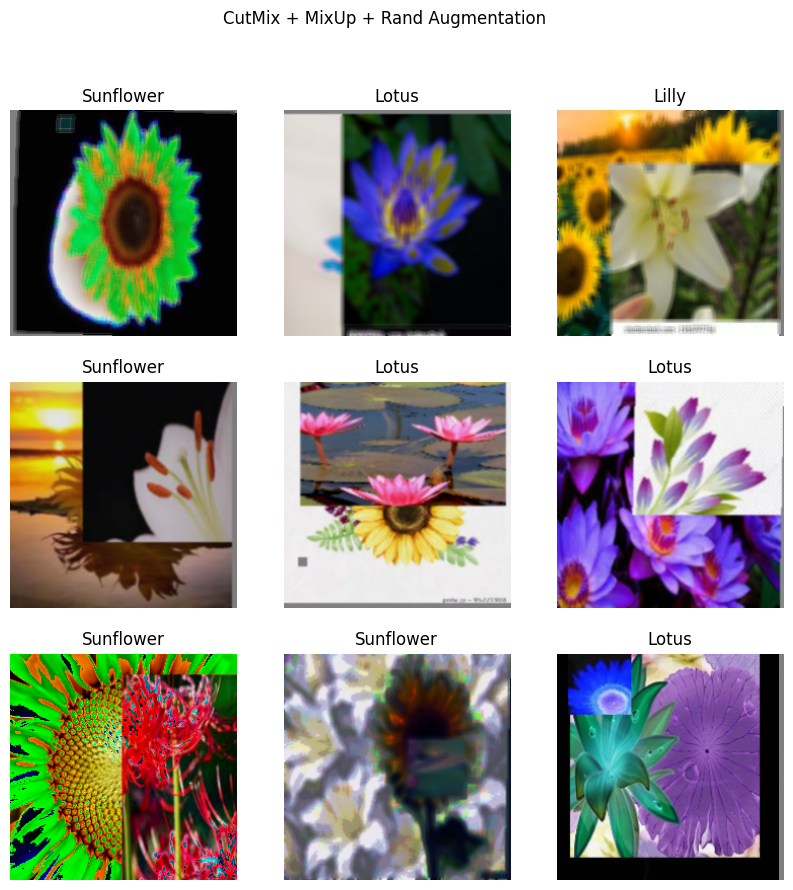

In [3]:
from data_loader import DataSet

dataset = DataSet(dataset_dir='flower_images')
train_data, val_data = dataset(validation_split=0.2)
val_ds = val_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

t1 = train_data.map(lambda x, y: (x, y))
t2 = train_data.map(lambda x, y: (x, y))

td = tf.data.Dataset.zip((t1, t2))
train_ds_cmu1 = td.map(dataset.cutmix).batch(BATCH_SIZE)
train_ds_cmu2 = td.map(dataset.cutmix).batch(BATCH_SIZE)
td = tf.data.Dataset.zip((train_ds_cmu1, train_ds_cmu2))
train_ds_cmu_mu = td.map(lambda train_ds_cmu1, train_ds_cmu2: dataset.mix_up(train_ds_cmu1, train_ds_cmu2, alpha=0.2))

train_ds_cmu_mu_rand = train_ds_cmu_mu.map(
    lambda x, y: (tf.py_function(dataset.rand_augment, [x], [tf.float32])[0], y),
    num_parallel_calls=tf.data.AUTOTUNE,
).prefetch(tf.data.AUTOTUNE)

# Plot results
image_batch, label_batch = next(iter(train_ds_cmu_mu_rand))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(dataset.class_names[np.argmax(label_batch[i].numpy())])
    plt.imshow(image_batch[i])
    plt.axis("off")
plt.suptitle('CutMix + MixUp + Rand Augmentation')
plt.show()

In [4]:
data_augmentation = keras.Sequential([
    # keras.layers.Rescaling(scale=1./255.0, offset=0),
    keras.layers.RandomFlip(),
    keras.layers.RandomRotation(0.20)
])

In [5]:
def ConvMixer(dim: int, patch_size: int, depth: int, kernel_size: int, num_classes: int):
    
    input = keras.Input(shape=image_shape + (3,))
    
    input = data_augmentation(input)
    x = keras.layers.Conv2D(filters=dim, kernel_size=patch_size, strides=patch_size)(input)
    x = keras.layers.Activation('gelu')(x)
    x1 = keras.layers.BatchNormalization()(x)
    
    for i in range(depth):
        x = keras.layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x1)
        # x = keras.layers.Conv2D(filters=dim, kernel_size=kernel_size, padding='same', groups=dim, activation='gelu')(x1)
        x = keras.layers.Activation('gelu')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.add([x1, x])
        
        x = keras.layers.Conv2D(filters=dim, kernel_size=1)(x)
        x = keras.layers.Activation('gelu')(x)
        x1 = keras.layers.BatchNormalization()(x)
    
    x = keras.layers.GlobalAvgPool2D()(x1)
    x = keras.layers.Flatten()(x)
    output = keras.layers.Dense(units=num_classes, activation='softmax')(x)
    
    
    return keras.Model(input, output)

In [6]:
model = ConvMixer(dim=512, depth=12, patch_size=7, kernel_size=8, num_classes=5)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 512)  75776       ['input_2[0][0]']                
                                                                                                  
 activation (Activation)        (None, 32, 32, 512)  0           ['conv2d[1][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 512)  2048       ['activation[1][0]']         

In [8]:
callbacks = [
    keras.callbacks.TensorBoard(), 
    keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
    keras.callbacks.ModelCheckpoint(filepath='checkpoints/convmixer-256-8-{epoch}.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy'),
    ]

In [9]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics='accuracy',
    )

history = model.fit(train_ds_cmu_mu_rand, epochs=50, batch_size=BATCH_SIZE, validation_data=val_ds, callbacks=callbacks, verbose='auto')

Epoch 1/50
400/400 [==============================] - 261s 560ms/step - loss: 1.4984 - accuracy: 0.3885 - val_loss: 2.0435 - val_accuracy: 0.2360 - lr: 0.0010
Epoch 2/50
400/400 [==============================] - 238s 565ms/step - loss: 1.4590 - accuracy: 0.4110 - val_loss: 2.3976 - val_accuracy: 0.2470 - lr: 0.0010
Epoch 3/50
400/400 [==============================] - 237s 564ms/step - loss: 1.4461 - accuracy: 0.4265 - val_loss: 1.6260 - val_accuracy: 0.3860 - lr: 0.0010
Epoch 4/50
400/400 [==============================] - 237s 563ms/step - loss: 1.4426 - accuracy: 0.4248 - val_loss: 1.4463 - val_accuracy: 0.3980 - lr: 0.0010
Epoch 5/50
400/400 [==============================] - 238s 564ms/step - loss: 1.3862 - accuracy: 0.4613 - val_loss: 1.3100 - val_accuracy: 0.4530 - lr: 0.0010
Epoch 6/50
400/400 [==============================] - 238s 567ms/step - loss: 1.3986 - accuracy: 0.4640 - val_loss: 1.2697 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 7/50
400/400 [==========================

Text(0.5, 0.98, 'Loss and Accuracy when using CutMix, Mixup & RandAugment')

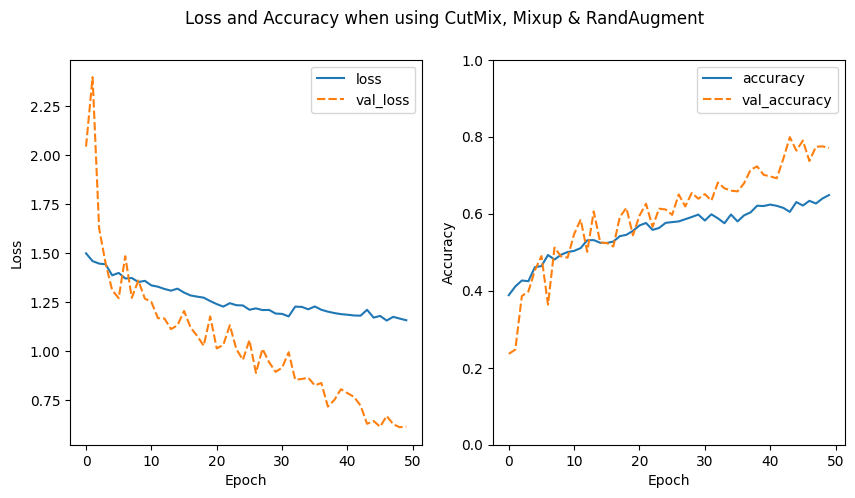

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = sns.lineplot(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']}, ax=axes[0])
ax.set(xlabel='Epoch', ylabel='Loss')
ax = sns.lineplot(data={'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}, ax=axes[1])
ax.set(xlabel='Epoch', ylabel='Accuracy', ylim=(0,1))
plt.suptitle("Loss and Accuracy when using CutMix, Mixup & RandAugment")